In [1]:
from gvuln import *
#from libSOGA import *
import matplotlib.pyplot as plt
from time import time 

torch.set_default_dtype(torch.float32)

# Geo-indistinguishability

## Without Loops

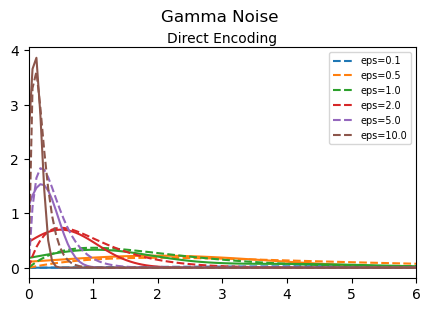

In [4]:
import matplotlib.pyplot as plt
from itertools import cycle

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(5, 3))

mean = torch.tensor(2.)

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

x = torch.linspace(0, 6, 100)

for eps in eps_list:

    # SOGA approximation
    program = 'noise = gm([_p1, _p2], [_mu1, _mu2], [_sigma1, _sigma2]);'
    compiledFile=compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    mean = torch.tensor(2.)
    scale = 1/eps
    _, pi1, pi2, mu1, mu2, sigma1, sigma2 = fit_gamma(mean, scale)
    pars = {'p1': pi1,
            'p2': pi2,
            'mu1': mu1,
            'mu2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2
            }
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    y_soga = output_dist.gm.pdf(x.reshape(-1, 1)).detach().numpy()

    y = Gamma(mean, eps).log_prob(x).exp()

    color = next(color_cycle)

    plt.plot(x.numpy(), y_soga, color=color)
    plt.plot(x.numpy(), y.numpy(), ls='--', label='eps={}'.format(round(eps.item(),2)), color=color)

plt.title('Gamma Noise \n')
plt.text(3., 4.35, 'Direct Encoding', ha='center', va='top')
plt.xlim(0,6)
plt.legend(fontsize=7)

In [5]:
vdelta_lb = {}
vdelta_ub = {}
vgauss_lb = {}
vgauss_ub = {}
vdelta = {}
vgauss = {}

cond_ent_noloop_lb = {}
cond_ent_noloop_ub = {}

mi_noloop_lb = {}
mi_noloop_ub = {}

kl_noloop_lb = {}
kl_noloop_ub = {}

sampling_time = 0.

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

for eps in eps_list:

    print('Eps = {}'.format(eps))

    # Computing noise    
    mean = torch.tensor(2.)
    scale = 1/eps

    _, pi1, pi2, mu1, mu2, sigma1, sigma2 = fit_gamma(mean, scale)

    pars = {'p1': pi1,
            'p2': pi2,
            'mu1': mu1,
            'mu2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2
            }
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    

    # Computing SOGA output
    compiledFile=compile2SOGA('Geo_ind.soga')
    cfg = produce_cfg(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    marg_dist = extract_marginal(output_dist, ['x', 'y', 'xAnon', 'yAnon'])
    marg_dist = aggregate_mixture(marg_dist)
    s_marg = extract_marginal(output_dist, ['x', 'y'])
    s_marg = aggregate_mixture(s_marg)

    compiledFile=compile2SOGA('Geo_ind_obs.soga')
    cfg = produce_cfg(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    s_marg_obs = extract_marginal(output_dist, ['x', 'y'])
    s_marg_obs = aggregate_mixture(s_marg_obs)

    vdelta_lb['{}'.format(eps)] = vdelta_lower_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vdelta_ub['{}'.format(eps)] = vdelta_upper_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vgauss_lb['{}'.format(eps)] = vgauss_lower_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)
    vgauss_ub['{}'.format(eps)] = vgauss_upper_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)
    
    start = time()
    vdelta['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=1000, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='delta', lr=0.001)
    vgauss['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=1000, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='gauss')
    end = time()
    sampling_time += end - start

    cond_ent_noloop_lb['{}'.format(eps)] = cond_entropy_lb(marg_dist, idx_o=[2,3])
    cond_ent_noloop_ub['{}'.format(eps)] = cond_entropy_ub(marg_dist, idx_o=[2,3])
    
    mi_noloop_lb['{}'.format(eps)] = mi_lb(marg_dist, idx_o=[2,3])
    mi_noloop_ub['{}'.format(eps)] = mi_ub(marg_dist, idx_o=[2,3])

    kl_noloop_lb['{}'.format(eps)] = kl_div_lb(s_marg_obs, s_marg)
    kl_noloop_ub['{}'.format(eps)] = kl_div_ub(s_marg_obs, s_marg)

print('Sampling time: {:.2f} seconds'.format(sampling_time))

Eps = 0.10000000149011612


KeyboardInterrupt: 

In [5]:
print('Delta Gain')
for key in vdelta_lb.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, vdelta_lb[key], vdelta[key], vdelta_ub[key]))

print('\n Gauss Gain')
for key in vdelta_lb.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, vgauss_lb[key], vgauss[key], vgauss_ub[key]))

print('\n Conditional Entropy')
for key in cond_ent_noloop_lb.keys():
    print('\t Eps = {}, lb = {}, ub= {}'.format(key, cond_ent_noloop_lb[key], cond_ent_noloop_ub[key]))

print('\n Mutual Information')
for key in mi_noloop_lb.keys():
    print('\t Eps = {}, lb = {}, ub= {}'.format(key, mi_noloop_lb[key], mi_noloop_ub[key]))

print('\n KL Divergence')
for key in kl_noloop_lb.keys():
    print('\t Eps = {}, lb = {}, ub= {}'.format(key, kl_noloop_lb[key], kl_noloop_ub[key]))
    

Delta Gain
	 Eps = 0.10000000149011612, lb = 0.0006466574850492179, exact=0.0021985985804349184, ub= 0.005208255723118782
	 Eps = 0.5, lb = 0.007347754668444395, exact=0.03608648106455803, ub= 0.05885932967066765
	 Eps = 1.0, lb = 0.021124575287103653, exact=0.11086677014827728, ub= 0.1767556369304657
	 Eps = 2.0, lb = 0.08608506619930267, exact=0.4912206828594208, ub= 0.688716471195221
	 Eps = 5.0, lb = 0.44746628403663635, exact=2.9492735862731934, ub= 3.5799779891967773
	 Eps = 10.0, lb = 2.5222463607788086, exact=15.091085433959961, ub= 20.178863525390625

 Gauss Gain
	 Eps = 0.10000000149011612, lb = 0.0039004944264888763, exact=0.01336649525910616, ub= 0.031423501670360565
	 Eps = 0.5, lb = 0.033111169934272766, exact=0.18570201843976974, ub= 0.26537108421325684
	 Eps = 1.0, lb = 0.054705407470464706, exact=0.39538903534412384, ub= 0.47827982902526855
	 Eps = 2.0, lb = 0.10070880502462387, exact=0.7704223394393921, ub= 0.8058916926383972
	 Eps = 5.0, lb = 0.11853039264678955, exa

In [6]:
from torch.distributions import Uniform

def orig_geo(n_samples=1000, scale=1.):
    x = Uniform(-90, 90).sample((n_samples,))
    y = Uniform(-180, 180).sample((n_samples,))
    r = Gamma(2., 1./scale).sample((n_samples,))
    theta = Uniform(0, 2*torch.pi).sample((n_samples,))
    x_anon = x + r * torch.cos(theta)
    y_anon = y + r * torch.sin(theta)
    return x_anon, y_anon

n_samples = 10_000_000

x_anon, y_anon = orig_geo(n_samples=n_samples, scale=1.)
torch.mean(x_anon), torch.mean(y_anon), torch.std(x_anon), torch.std(y_anon)

(tensor(-0.0016), tensor(-0.0133), tensor(51.9891), tensor(103.9361))

In [ ]:
marg = extract_marginal(output_dist, ['xAnon', 'yAnon'])
marg.gm.mean(), marg.gm.cov()

(tensor([10., 10.], grad_fn=<SumBackward1>),
 tensor([[1.0000e-05, 0.0000e+00],
         [0.0000e+00, 1.0000e-05]], grad_fn=<AddBackward0>))

## Rejection Sampling Loop 

In [6]:
from torch.distributions import Uniform

def rejection_sampling():
    while True:
        w = Uniform(0,20).sample()
        u = Uniform(0,1).sample()
        if u <= torch.exp(-w):
            return w
        
def rejection_sampling_rewrite():
    w = Uniform(0,20).sample()
    u = Uniform(0,1).sample()
    while u > torch.exp(-w):
        w = Uniform(0,20).sample()
        u = Uniform(0,1).sample()
    return w

def gamma_sampling(mean, scale):
    sum_exps = torch.tensor(0.)
    for _ in range(mean):
        sum_exps += rejection_sampling_rewrite()
    return sum_exps / scale

mean = torch.tensor(2)
scale = torch.tensor(1.0)

samples = []
for i in range(10000):
    samples.append(gamma_sampling(mean, scale))

x = torch.linspace(0, 8, 100)
y = torch.distributions.Gamma(mean, 1/scale).log_prob(x).exp()

_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(x.numpy(), y.numpy())


KeyboardInterrupt: 

In [7]:
# Checking i.i.d.-ness in soga

# program defining the distribution before entering the loop

prog1 = '''
w = uniform([0,20], 2);
u = uniform([0, 1], 2);
'''

compiledFile=compile2SOGA_text(prog1)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={})
marg1 = extract_marginal(output_dist, ['w', 'u'])

# program defining the distribution after one iteration of the loop

prog2 = '''
w = uniform([0,20], 2);
u = uniform([0, 1], 2);
expw = 0 - w;
expw = exp(expw);
observe(u - expw > 0);
w = uniform([0,20], 2);
u = uniform([0, 1], 2);
'''

compiledFile=compile2SOGA_text(prog2)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={})
marg2 = extract_marginal(output_dist, ['w', 'u'])
marg2 = aggregate_mixture(marg2)

torch.all(marg1.gm.pi == marg2.gm.pi), torch.all(marg1.gm.mu == marg2.gm.mu), torch.all(marg1.gm.sigma == marg2.gm.sigma)

(tensor(True), tensor(True), tensor(True))

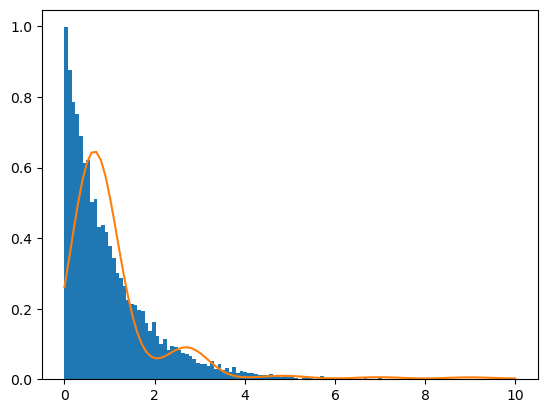

In [7]:
# The approximation we get using SOGA 

from torch.distributions import Exponential

samples = Exponential(1.).sample((10000,))
_ = plt.hist(samples, bins=100, density=True)

program = '''
w = uniform([0,20], 10);
u = uniform([0, 1], 10);
expw = 0 - w;
expw = exp(expw);
observe(u - expw <= 0);
'''

compiledFile = compile2SOGA_text(program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg)
marg = extract_marginal(output_dist, ['w'])

x = torch.linspace(0, 10, 100)
y = marg.gm.pdf(x.reshape(-1, 1)).detach().numpy()
plt.plot(x.numpy(), y)

In [9]:
# Programs 

noise_program = '''
w1 = uniform([0,20], 10);
u1 = uniform([0, 1], 10);
expw1 = 0 - w1;
expw1 = exp(expw1);
observe(u1 - expw1 <= 0);   
w2 = uniform([0,20], 10);
u2 = uniform([0, 1], 10);
expw2 = 0 - w2;
expw2 = exp(expw2);
observe(u2 - expw2 <= 0);  
r = w1 + w2;
r = _rate*r;
'''

program = '''
x = uniform([-90, 90], 2);
y = uniform([-180, 180], 2);

r = {};

theta = uniform([0, 6.28], 2);

cosTheta = cos(theta);
xAnon = r*cosTheta;
xAnon = x + xAnon;

sinTheta = sin(theta);
yAnon = r*sinTheta;
yAnon = y + yAnon;
'''


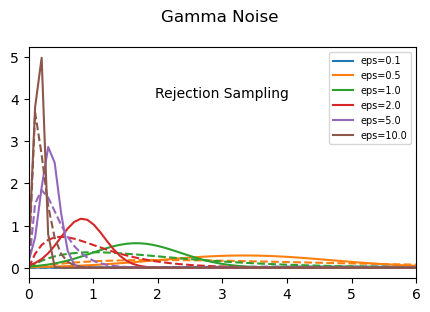

In [39]:
# Checking noise approximation

from itertools import cycle

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(5, 3))

for eps in [0.1, 0.5, 1., 2., 5., 10.]:

    x = torch.linspace(0, 10, 100)

    # Computing SOGA approximation
    compiledFile = compile2SOGA_text(noise_program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg, params_dict={'rate': 1/eps})
    marg = extract_marginal(output_dist, ['r'])
    marg = aggregate_mixture(marg)

    pruned_marg = Dist(marg.var_list, GaussianMix(torch.clone(marg.gm.pi), torch.clone(marg.gm.mu), torch.clone(marg.gm.sigma)))
    pruned_marg = ranking_prune(pruned_marg, 10)

    y_soga = marg.gm.pdf(x.reshape(-1, 1)).detach().numpy()
    y_pruned = pruned_marg.gm.pdf(x.reshape(-1, 1)).detach().numpy()

    # Real density
    y = Gamma(2, eps).log_prob(x).exp().detach().numpy()
    
    color = next(color_cycle)

    plt.plot(x.numpy(), y, ls='--')
    #plt.plot(x.numpy(), y_soga, label='SOGA')
    plt.plot(x.numpy(), y_pruned, color=color, label='eps={}'.format(round(eps,2)))

plt.title('Gamma Noise \n')
plt.text(3., 4.3, 'Rejection Sampling', ha='center', va='top')
plt.xlim(0,6)
plt.legend(fontsize=7)

In [5]:
eps = 10.

print('Eps: ', eps)

# creates the noise distribution
compiledFile = compile2SOGA_text(noise_program)
cfg = produce_cfg_text(compiledFile)
noise_dist = start_SOGA(cfg, params_dict={'rate': 1/eps})
noise_marg = extract_marginal(noise_dist, ['r'])
noise_marg = aggregate_mixture(noise_marg)
pruned_noise_marg = ranking_prune(noise_marg, 100)
gm_str = from_gm_to_string(pruned_noise_marg.gm)

# adds the noise distribution to the program
formatted_program = program.format(gm_str)
compiledFile=compile2SOGA_text(formatted_program)
cfg = produce_cfg_text(compiledFile)

# computes the output of the program without observations
output_dist = start_SOGA(cfg, params_dict={})
marg_dist = extract_marginal(output_dist, ['x', 'y', 'xAnon', 'yAnon'])
marg_dist = aggregate_mixture(marg_dist)   

print(marg_dist.gm.mean())


eps = 5.

print('Eps: ', eps)

# creates the noise distribution
compiledFile = compile2SOGA_text(noise_program)
cfg = produce_cfg_text(compiledFile)
noise_dist = start_SOGA(cfg, params_dict={'rate': 1/eps})
noise_marg = extract_marginal(noise_dist, ['r'])
noise_marg = aggregate_mixture(noise_marg)
pruned_noise_marg = ranking_prune(noise_marg, 100)
gm_str = from_gm_to_string(pruned_noise_marg.gm)

# adds the noise distribution to the program
formatted_program = program.format(gm_str)
compiledFile=compile2SOGA_text(formatted_program)
cfg = produce_cfg_text(compiledFile)

# computes the output of the program without observations
output_dist = start_SOGA(cfg, params_dict={})
marg_dist = extract_marginal(output_dist, ['x', 'y', 'xAnon', 'yAnon'])
marg_dist = aggregate_mixture(marg_dist)   

print(marg_dist.gm.mean())

Eps:  10.0
tensor([ 0.0000e+00,  0.0000e+00, -1.1028e-04,  1.4901e-07])
Eps:  5.0
tensor([ 0.0000e+00,  0.0000e+00, -2.2043e-04,  2.0862e-07])


In [34]:
vdelta_lb = {}
vdelta_ub = {}
vgauss_lb = {}
vgauss_ub = {}
vdelta = {}
vgauss = {}

cond_ent_rej_lb = {}
cond_ent_rej_ub = {}

mi_rej_lb = {}
mi_rej_ub = {}

kl_rej_lb = {}
kl_rej_ub = {}

sampling_time = 0.

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])


for eps in eps_list:

    print('Eps: ', eps)

    # creates the noise distribution
    compiledFile = compile2SOGA_text(noise_program)
    cfg = produce_cfg_text(compiledFile)
    noise_dist = start_SOGA(cfg, params_dict={'rate': 1/eps})
    noise_marg = extract_marginal(noise_dist, ['r'])
    noise_marg = aggregate_mixture(noise_marg)
    pruned_noise_marg = ranking_prune(noise_marg, 2)
    gm_str = from_gm_to_string(pruned_noise_marg.gm)

    # adds the noise distribution to the program
    formatted_program = program.format(gm_str)
    compiledFile=compile2SOGA_text(formatted_program)
    cfg = produce_cfg_text(compiledFile)

    program_obs = formatted_program + '\n observe(xAnon==10.);\n observe(yAnon==10.);'
    compiledFile=compile2SOGA_text(program_obs)
    cfg_obs = produce_cfg_text(compiledFile)

    # computes the output of the program without observations
    output_dist = start_SOGA(cfg, params_dict={})
    marg_dist = extract_marginal(output_dist, ['x', 'y', 'xAnon', 'yAnon'])
    marg_dist = aggregate_mixture(marg_dist)    
    s_marg = extract_marginal(marg_dist, ['x', 'y'])
    s_marg = aggregate_mixture(s_marg)
    # output of the program with observations
    output_dist_obs = start_SOGA(cfg_obs, params_dict={})
    s_marg_obs = extract_marginal(output_dist_obs, ['x', 'y'])
    s_marg_obs = aggregate_mixture(s_marg_obs)

    # metrics computation
    vdelta_lb['{}'.format(eps)] = vdelta_lower_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vdelta_ub['{}'.format(eps)] = vdelta_upper_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vgauss_lb['{}'.format(eps)] = vgauss_lower_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)
    vgauss_ub['{}'.format(eps)] = vgauss_upper_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)

    start = time()
    vdelta['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=1000, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='delta', lr=0.001)
    vgauss['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=1000, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='gauss', lr=0.001)
    end = time()
    sampling_time += end - start

    cond_ent_rej_lb['{}'.format(eps)] = cond_entropy_lb(marg_dist, idx_o=[2,3])
    cond_ent_rej_ub['{}'.format(eps)] = cond_entropy_ub(marg_dist, idx_o=[2,3])
    
    mi_rej_lb['{}'.format(eps)] = mi_lb(marg_dist, idx_o=[2,3])
    mi_rej_ub['{}'.format(eps)] = mi_ub(marg_dist, idx_o=[2,3])

    kl_rej_lb['{}'.format(eps)] = kl_div_lb(s_marg_obs, s_marg)
    kl_rej_ub['{}'.format(eps)] = kl_div_ub(s_marg_obs, s_marg)
    

print('Sampling time: {:.2f} seconds'.format(sampling_time))
    

Eps:  tensor(0.1000)
Eps:  tensor(0.5000)
Eps:  tensor(1.)
Eps:  tensor(2.)
Eps:  tensor(5.)
Eps:  tensor(10.)
Sampling time: 512.81 seconds


In [35]:
print('Delta Gain')
for key in vdelta_lb.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, vdelta_lb[key], vdelta[key], vdelta_ub[key]))

print('\n Gauss Gain')
for key in vdelta_lb.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, vgauss_lb[key], vgauss[key], vgauss_ub[key]))

#print('Delta Gain')
#for key in vdelta_lb.keys():
#    print('\t Eps = {}, lb = {}, ub= {}'.format(key, vdelta_lb[key], vdelta_ub[key]))

#print('\n Gauss Gain')
#for key in vdelta_lb.keys():
#    print('\t Eps = {}, lb = {}, ub= {}'.format(key, vgauss_lb[key], vgauss_ub[key]))

print('\n Conditional Entropy')
for key in cond_ent_rej_lb.keys():
    print('\t Eps = {}, lb = {}, ub= {}'.format(key, cond_ent_rej_lb[key], cond_ent_rej_ub[key]))

print('\n Mutual Information')
for key in mi_rej_lb.keys():
    print('\t Eps = {}, lb = {}, ub= {}'.format(key, mi_rej_lb[key], mi_rej_ub[key]))

print('\n KL Divergence')
for key in kl_rej_lb.keys():
    print('\t Eps = {}, lb = {}, ub= {}'.format(key, kl_rej_lb[key], kl_rej_ub[key]))



Delta Gain
	 Eps = 0.10000000149011612, lb = 1.8568220184533857e-05, exact=8.572014485253021e-05, ub= 0.0002718993346206844
	 Eps = 0.5, lb = 0.0022315855603665113, exact=0.018400300294160843, ub= 0.034486934542655945
	 Eps = 1.0, lb = 0.012750223278999329, exact=0.09805510938167572, ub= 0.1951128989458084
	 Eps = 2.0, lb = 0.05760617181658745, exact=0.43762680888175964, ub= 0.8776345252990723
	 Eps = 5.0, lb = 0.3728440999984741, exact=2.8332568407058716, ub= 5.681351661682129
	 Eps = 10.0, lb = 1.5117260217666626, exact=9.774590015411377, ub= 22.995323181152344

 Gauss Gain
	 Eps = 0.10000000149011612, lb = 0.00011646930943243206, exact=0.0005206909263506532, ub= 0.0017052196199074388
	 Eps = 0.5, lb = 0.011768041178584099, exact=0.1003895103931427, ub= 0.1767968237400055
	 Eps = 1.0, lb = 0.037951257079839706, exact=0.3329372704029083, ub= 0.5380735993385315
	 Eps = 2.0, lb = 0.060990624129772186, exact=0.6729767620563507, ub= 0.8332599401473999
	 Eps = 5.0, lb = 0.07206518203020096

## Von Neumann Loop

In [48]:
from torch.distributions import Uniform

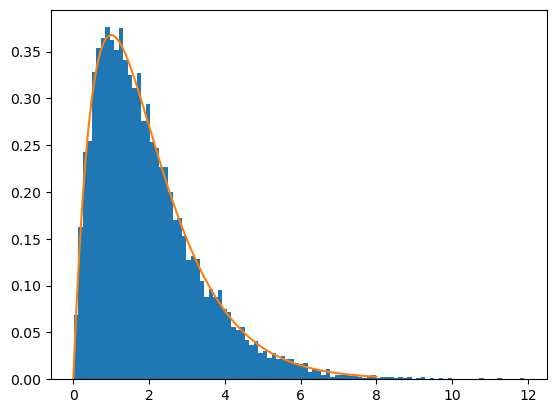

In [59]:
def von_neumann_exponential():
    K = 0
    while True:
        x = Uniform(0,1).sample()
        x1 = x
        x_next = Uniform(0,1).sample()
        n = 1
        while x > x_next:
            x = x_next
            x_next = Uniform(0,1).sample()
            if n == 0:
                n = 1
            elif n == 1:
                n = 0
        if n == 1:
            return K + x1
        else:
            K = K + 1

def von_neumann_rewrite():
    K = -1
    n = 0
    while (n==0):
        K += 1
        n = 1
        x = Uniform(0,1).sample()
        x1 = x
        x_next = Uniform(0,1).sample()
        if x > x_next:
            x = x_next
            x_next = Uniform(0,1).sample()
            if n== 0:
                n = 1
            elif n == 1:
                n = 0
        while x > x_next:
            x = x_next
            x_next = Uniform(0,1).sample() 
            if n == 0:
                n = 1
            elif n == 1:
                n = 0      
    return K + x1


def gamma_sampling(mean, scale):
    sum_exps = torch.tensor(0.)
    for _ in range(mean):
        sum_exps += von_neumann_rewrite()
    return sum_exps / scale

mean = torch.tensor(2)
scale = torch.tensor(1.0)

samples = []
for i in range(10000):
    samples.append(gamma_sampling(mean, scale))

x = torch.linspace(0, 8, 100)
y = torch.distributions.Gamma(mean, 1/scale).log_prob(x).exp()

_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(x.numpy(), y.numpy())


In [ ]:
plt.title('Gamma Noise \n Rejection Sampling', fontsize={'Gamma Noise': 12, 'Rejection Sampling': 10})
#        x_next = Uniform(0,1).sample()
#        if x > x_next:
#            x = x_next
#            x_next = Uniform(0,1).sample()
#            if n== 0:
#                n = 1
#            elif n == 1:
#                n = 0
#        while x > x_next:
#            x = x_next
#            x_next = Uniform(0,1).sample() 
#            if n == 0:
#                n = 1
#            elif n == 1:
#                n = 0      
#    return K + x1

In [79]:
marg1.gm.mu, marg2.gm.mu

(tensor([[0.1686, 0.3314, 1.0000],
         [0.4666, 0.5334, 1.0000],
         [0.2480, 0.7520, 1.0000],
         [0.6686, 0.8314, 1.0000],
         [0.1686, 0.2500, 0.0000],
         [0.2480, 0.2500, 0.0000],
         [0.4666, 0.2500, 0.0000],
         [0.6686, 0.2500, 0.0000],
         [0.1686, 0.7500, 0.0000],
         [0.2480, 0.7500, 0.0000],
         [0.4666, 0.7500, 0.0000],
         [0.6686, 0.7500, 0.0000]]),
 tensor([[0.2213, 0.2500, 0.0000],
         [0.4843, 0.2500, 0.0000],
         [0.4682, 0.2500, 0.0000],
         [0.7213, 0.2500, 0.0000],
         [0.2213, 0.7500, 0.0000],
         [0.4843, 0.7500, 0.0000],
         [0.4682, 0.7500, 0.0000],
         [0.7213, 0.7500, 0.0000],
         [0.1283, 0.2500, 1.0000],
         [0.1674, 0.2500, 1.0000],
         [0.2248, 0.2500, 1.0000],
         [0.2463, 0.2500, 1.0000],
         [0.3736, 0.2500, 1.0000],
         [0.4625, 0.2500, 1.0000],
         [0.5171, 0.2500, 1.0000],
         [0.6283, 0.2500, 1.0000],
         [0.1283, 